In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle

from keras.callbacks import ModelCheckpoint
#!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=2
CHANNELS=3
print(tf. __version__) 

2.9.1


In [4]:
load_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Newdata",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6524 files belonging to 5 classes.


In [5]:
class_names= load_data.class_names
class_names

['Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Jackfruit___Bacterial_spot',
 'Jackfruit___healthy']

In [6]:
for image_batch,label_batch in load_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(2, 256, 256, 3)
[1 3]


In [7]:
len(load_data)

3262

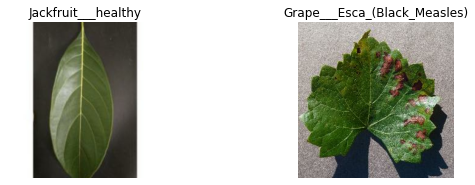

In [8]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in load_data.take(1):
    for i in range(0,2):
        plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partition_tf(data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)
    train_data=data.take(train_size)
    
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)
    return train_data,val_data,test_data
    

In [10]:
train_data,val_data,test_data=get_dataset_partition_tf(load_data)

In [11]:
len(train_data)

2609

In [12]:
len(val_data)

326

In [13]:
len(test_data)

327

In [14]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale =tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)  

])

In [16]:
data_augmentation =tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)  

])

In [17]:
#for image, _ in train_ds.take(1):
 # plt.figure(figsize=(10, 10))
#  first_image = image[0]
 # for i in range(9):
  #  ax = plt.subplot(3, 3, i + 1)
   # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #plt.imshow(augmented_image[0] / 255)
    #plt.axis('off')

In [18]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

overall_model = models.Sequential([
    resize_and_rescale,#data_augmentation,
    layers.Conv2D(16,(3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')

])


In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)

#overall_model = models.Sequential([
    resize_and_rescale,data_augmentation,
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [19]:
overall_model.build(input_shape=input_shape)

In [20]:
overall_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (2, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (2, 254, 254, 16)         448       
                                                                 
 max_pooling2d (MaxPooling2D  (2, 127, 127, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (2, 125, 125, 32)         4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (2, 62, 62, 32)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (2, 60, 60, 64)          

In [21]:
base_learning_rate = 0.0001

overall_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [22]:

history=overall_model.fit(
    train_data,
    epochs=5,
    batch_size=2,
    validation_data=val_data

)

Epoch 1/5
2609/2609 [==============================] - 88s 25ms/step - loss: 0.3305 - accuracy: 0.8649 - val_loss: 0.2060 - val_accuracy: 0.9233
Epoch 2/5
2609/2609 [==============================] - 42s 16ms/step - loss: 0.1267 - accuracy: 0.9484 - val_loss: 0.0839 - val_accuracy: 0.9724
Epoch 3/5
2609/2609 [==============================] - 30s 12ms/step - loss: 0.0803 - accuracy: 0.9688 - val_loss: 0.0469 - val_accuracy: 0.9785
Epoch 4/5
2609/2609 [==============================] - 30s 12ms/step - loss: 0.0602 - accuracy: 0.9789 - val_loss: 0.0459 - val_accuracy: 0.9816
Epoch 5/5
2609/2609 [==============================] - 30s 12ms/step - loss: 0.0413 - accuracy: 0.9839 - val_loss: 0.0251 - val_accuracy: 0.9939


In [23]:
scores=overall_model.evaluate(test_data)

327/327 [==============================] - 14s 7ms/step - loss: 0.0203 - accuracy: 0.9924


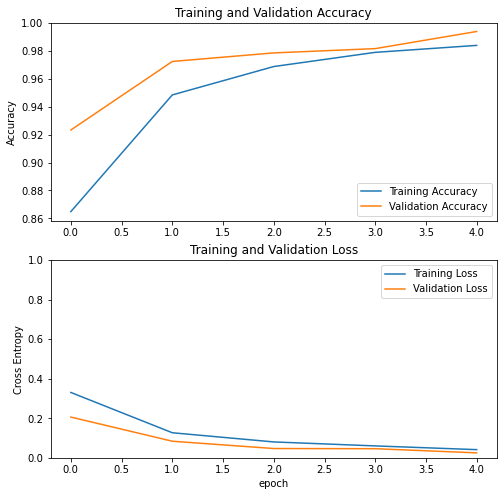

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
#serial model
model_json = overall_model.to_json()
with open("project.json","w") as json_file:
    json_file.write(model_json)

In [26]:
#serial weight
overall_model.save_weights("project.h5")

In [2]:
#load json model
json_file=open("project.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

NameError: name 'model_from_json' is not defined

In [ ]:
#load weight
loaded_model.load_weights("project.h5")

Actual label :  Jackfruit___healthy
1/1 [==============================] - 1s 995ms/step
predicted label :  Jackfruit___healthy


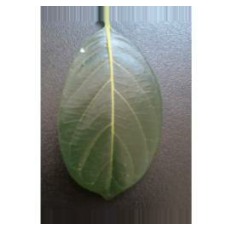

In [27]:
for image_batch,lables_batch in test_data.take(1):
    image=image_batch[0].numpy().astype("uint8")
    label=lables_batch[0].numpy()
    
    plt.imshow(image)
    print("Actual label : ",class_names[label])
    
    
    batch_prediction=overall_model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [29]:
def predict (overall_model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    prediction = overall_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 23ms/step


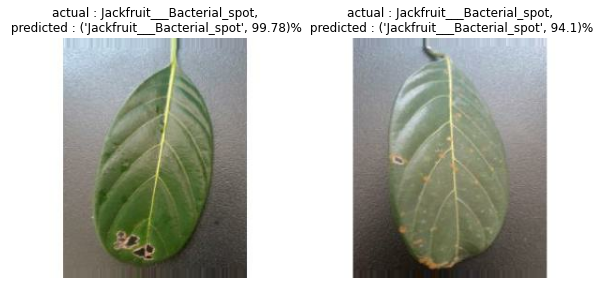

In [31]:
plt.figure(figsize=(15,15))
for image, labels in test_data.take(2):
    for i in range(2):
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.subplot(3,3,i+1)
        predicted_class= predict(overall_model,image[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"actual : {actual_class},\n predicted : {predicted_class}%")
        plt.axis("off")